#### クラス編成
- 課題整理(条件)
  - 全生徒を1つのクラスに割り当てる
  - クラス人数は39人以上40人以下
  - 男子生徒、女子生徒は20人以下
  - 学力試験のクラス平均点は学年平均の±10点
  - リーダ気質の生徒を2人以上
  - 特別支援生徒は1人以下
  - 特定ペアの生徒は別クラスとする

- List
  - $S$ : Students list
  - $C$ : Class list
  - $S_{male}$ : Men list
  - $S_{female}$ : Women list
  - $S_{leader}$ : leaders list
  - $S_{support}$ : supports list
  - $S_{specific}$ : Specific Pairs list
- Variable
  - $x_{s,c} \in \{0, 1\} (s\in S, c\in C)$
- Constant
  - $score_s$ : Score of students
  - $score_{mean}$ : Score of mean
- Constraints
  1. $\sum_{c\in C} x_{s,c} = 1 \quad (s \in S)$
  2. $\sum_{s\in S} x_{s,c} \ge 39 \quad (c \in C), \quad \sum_{s\in S} x_{s,c} \le 40 \quad (c \in C)$
  3. $\sum_{s\in S_{male}} x_{s,c} \le 20 \quad (c \in C), \quad \sum_{s\in S_{female}} x_{s,c} \le 20 \quad (c \in C)$
  4. $\sum_{S_{leader}}x_{s,c} \le 2$
  5. $\sum_{S_{support}}x_{s,c} \le 1$
  6. $(score_{mean}-10) \cdot \sum_{s\in S} x_{s,c} \ge \sum_{s\in S} score_s \cdot x_{s,c}, \quad \sum_{s\in S} score_s \cdot x_{s,c} \le (score_{mean}+10) \cdot \sum_{s\in S} x_{s,c}$
  7. $x_{s1,c} + x_{s2,c} \le 1$
- Objective
  - None(Maximize)

In [17]:
from pulp import LpProblem, LpVariable, LpMaximize, LpStatus, lpSum, value
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
# from itertools import product
import math
import time

In [18]:
print(glob('../*/*school/*.csv'))
students_df = pd.read_csv(glob('../*/*school/students.csv')[0])
pairs_df = pd.read_csv(glob('../*/*school/student_pairs.csv')[0])

['..\\PyOptBook-main\\3.school\\students.csv', '..\\PyOptBook-main\\3.school\\student_pairs.csv']


In [19]:
display(students_df.head(3))
display(pairs_df)

,student_id,gender,leader_flag,support_flag,score
0,1,0,0,0,335
1,2,1,0,0,379
2,3,0,0,0,350


,student_id1,student_id2
0,118,189
1,72,50
2,314,233


DataFrame にクラスを追加し変数を定義

In [20]:
student_num = students_df['student_id'].count()
count_in_class = 40
class_num = math.ceil(student_num / count_in_class)

s_df = pd.DataFrame()
for i in range(class_num):
    tmp_df = students_df.copy()
    tmp_df.columns = ['id', 'gender', 'leader', 'support', 'score']
    tmp_df['class'] = chr(i+65)
    # display(tmp_df.head())
    s_df = pd.concat([s_df, tmp_df])
s_df.shape

(2544, 6)

In [21]:
s_df['variable'] = [LpVariable(f'x_{id:03}{c}', cat='Binary') for id, c in zip(s_df['id'], s_df['class'])]
s_df['score * var'] = s_df['score'] * s_df['variable']
print(s_df.shape)
s_df.head(3)

(2544, 8)


,id,gender,leader,support,score,class,variable,score * var
0,1,0,0,0,335,A,x_001A,{x_001A: 335}
1,2,1,0,0,379,A,x_002A,{x_002A: 379}
2,3,0,0,0,350,A,x_003A,{x_003A: 350}


数理モデル定義

In [22]:
np.random.seed(1)
problem = LpProblem('ClassAssignmentProblemByPandas', LpMaximize)

for k, v in s_df.groupby('id'):
    problem += lpSum(v['variable']) == 1

for k, v in s_df.groupby('class'):
    
    problem += lpSum(v['variable']) >= 39
    problem += lpSum(v['variable']) <= 40

    problem += lpSum(v['variable'][v['gender'] == 1]) <= 20
    problem += lpSum(v['variable'][v['gender'] == 0]) <= 20

    problem += lpSum(v['variable'][v['leader'] == 1]) >= 2

    problem += lpSum(v['variable'][v['support'] == 1]) <= 1

    problem += (students_df['score'].mean() - 10) * lpSum(v['variable']) <= lpSum(v['variable'] * v['score'])
    problem += (students_df['score'].mean() + 10) * lpSum(v['variable']) >= lpSum(v['variable'] * v['score'])

for i, s1, s2 in pairs_df.itertuples():
    for k, v in s_df.groupby(['class']):
        problem += lpSum([v['variable'][v['id'] == s1], v['variable'][v['id'] == s2]]) <= 1
problem

ClassAssignmentProblemByPandas:
MAXIMIZE
None
SUBJECT TO
_C1: x_001A + x_001B + x_001C + x_001D + x_001E + x_001F + x_001G + x_001H = 1

_C2: x_002A + x_002B + x_002C + x_002D + x_002E + x_002F + x_002G + x_002H = 1

_C3: x_003A + x_003B + x_003C + x_003D + x_003E + x_003F + x_003G + x_003H = 1

_C4: x_004A + x_004B + x_004C + x_004D + x_004E + x_004F + x_004G + x_004H = 1

_C5: x_005A + x_005B + x_005C + x_005D + x_005E + x_005F + x_005G + x_005H = 1

_C6: x_006A + x_006B + x_006C + x_006D + x_006E + x_006F + x_006G + x_006H = 1

_C7: x_007A + x_007B + x_007C + x_007D + x_007E + x_007F + x_007G + x_007H = 1

_C8: x_008A + x_008B + x_008C + x_008D + x_008E + x_008F + x_008G + x_008H = 1

_C9: x_009A + x_009B + x_009C + x_009D + x_009E + x_009F + x_009G + x_009H = 1

_C10: x_010A + x_010B + x_010C + x_010D + x_010E + x_010F + x_010G + x_010H
 = 1

_C11: x_011A + x_011B + x_011C + x_011D + x_011E + x_011F + x_011G + x_011H
 = 1

_C12: x_012A + x_012B + x_012C + x_012D + x_012E + x_012F +

In [33]:
time_start = time.time()
status = problem.solve()
time_stop = time.time()

print('Status:', LpStatus[status])
print(f'Calculating Time: {time_stop - time_start:.3f} (sec)')

Status: Optimal
Calculating Time: 0.358 (sec)


In [24]:
s_df['result'] = s_df['variable'].apply(value)
result_df = s_df[s_df['result'] == 1]
result_df = result_df.sort_values('id').reset_index(drop=True)

C2Ss = {}
for c in result_df['class'].sort_values().unique():
    C2Ss[c] = result_df['id'][result_df['class'] == c].to_list()

for c, Ss in C2Ss.items():
    print(f'Class: {c}')
    print(f'Num: {len(Ss)}')
    print(f'id: {Ss}')
    print('*' * 5)

Class: A
Num: 39
id: [18, 19, 35, 39, 40, 51, 63, 65, 78, 83, 88, 97, 99, 128, 130, 136, 137, 145, 148, 165, 166, 168, 173, 175, 179, 193, 203, 206, 224, 233, 239, 243, 246, 259, 264, 267, 284, 291, 298]
*****
Class: B
Num: 40
id: [12, 15, 29, 36, 42, 52, 58, 67, 68, 70, 84, 87, 90, 104, 109, 112, 124, 133, 147, 150, 167, 172, 180, 184, 197, 199, 204, 209, 226, 240, 244, 270, 281, 293, 295, 301, 304, 310, 312, 313]
*****
Class: C
Num: 40
id: [17, 25, 26, 45, 46, 47, 57, 64, 75, 80, 86, 94, 100, 103, 105, 111, 122, 143, 144, 153, 161, 174, 182, 185, 191, 195, 205, 212, 215, 228, 234, 235, 248, 272, 279, 288, 289, 303, 307, 308]
*****
Class: D
Num: 40
id: [2, 4, 6, 11, 13, 27, 53, 61, 66, 73, 74, 76, 79, 89, 92, 98, 116, 117, 123, 146, 176, 187, 194, 213, 214, 216, 222, 223, 229, 231, 232, 251, 266, 275, 287, 292, 296, 299, 316, 317]
*****
Class: E
Num: 40
id: [10, 21, 28, 41, 43, 44, 48, 49, 82, 85, 91, 93, 101, 120, 125, 139, 140, 152, 158, 160, 164, 170, 181, 183, 190, 198, 200, 208, 

In [25]:
result_df.head(3)

,id,gender,leader,support,score,class,variable,score * var,result
0,1,0,0,0,335,F,x_001F,{x_001F: 335},1.0
1,2,1,0,0,379,D,x_002D,{x_002D: 379},1.0
2,3,0,0,0,350,H,x_003H,{x_003H: 350},1.0


In [26]:
result_df.groupby(['class'])['id'].count()

class
A    39
B    40
C    40
D    40
E    40
F    40
G    39
H    40
Name: id, dtype: int64

In [27]:
result_df.groupby(['class', 'gender'])['id'].count()

class  gender
A      0         20
       1         19
B      0         20
       1         20
C      0         20
       1         20
D      0         20
       1         20
E      0         20
       1         20
F      0         20
       1         20
G      0         20
       1         19
H      0         20
       1         20
Name: id, dtype: int64

In [28]:
result_df.groupby(['class', 'leader'])['id'].count()

class  leader
A      0         37
       1          2
B      0         38
       1          2
C      0         37
       1          3
D      0         38
       1          2
E      0         38
       1          2
F      0         38
       1          2
G      0         37
       1          2
H      0         38
       1          2
Name: id, dtype: int64

In [29]:
result_df.groupby(['class', 'support'])['id'].count()

class  support
A      0          38
       1           1
B      0          40
C      0          40
D      0          39
       1           1
E      0          40
F      0          39
       1           1
G      0          39
H      0          39
       1           1
Name: id, dtype: int64

In [30]:
for i, s1, s2 in pairs_df.itertuples():
    print(result_df[['id', 'class']][result_df['id'] == s1].values, result_df[['id', 'class']][result_df['id'] == s2].values)

[[118 'F']] [[189 'G']]
[[72 'G']] [[50 'F']]
[[314 'E']] [[233 'A']]


In [31]:
class_score_mean = result_df.groupby('class').sum()['score'] / result_df.groupby('class').count()['id']
class_score_mean - students_df['score'].mean()

class
A    6.560474
B   -8.719654
C   -9.669654
D    9.355346
E    9.180346
F   -9.894654
G    9.098936
H   -5.519654
dtype: float64

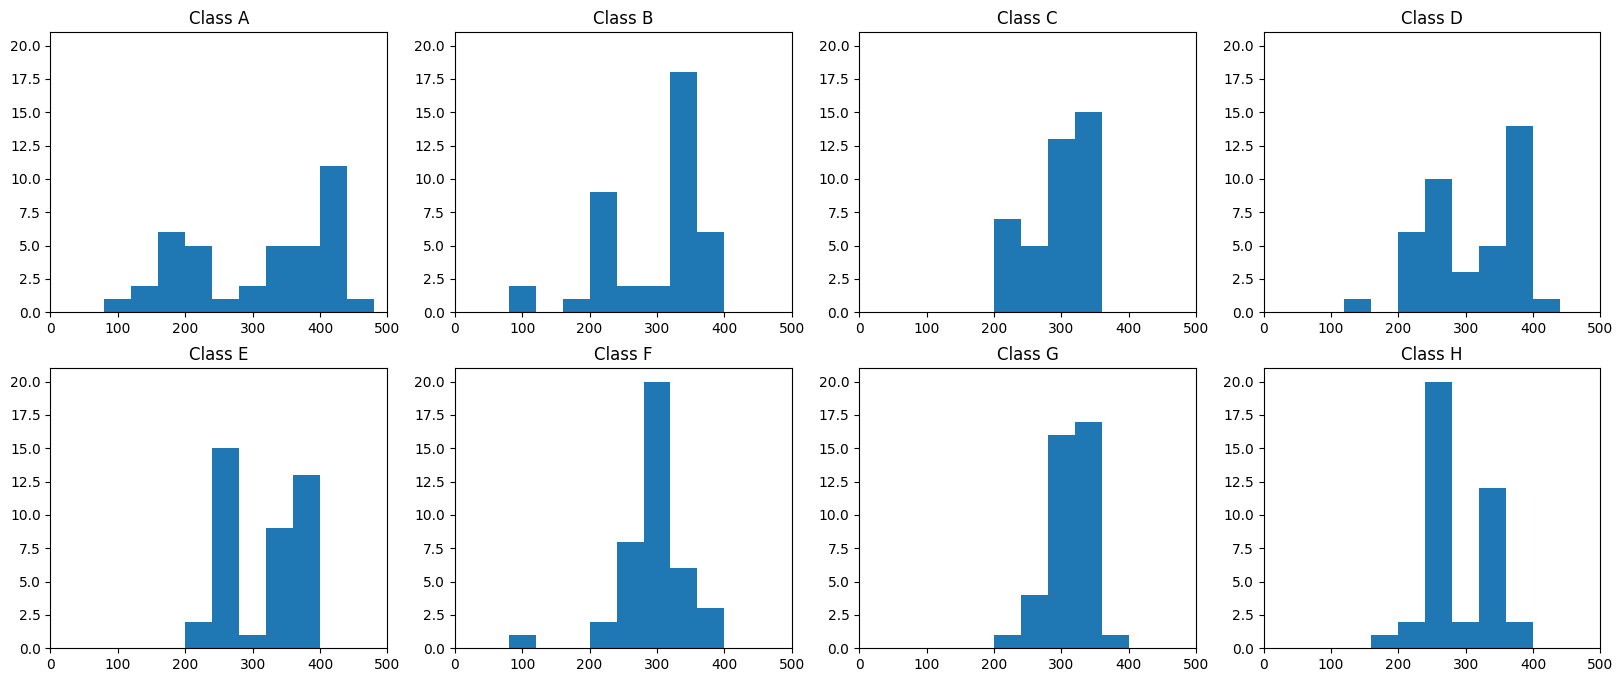

In [32]:
plt.figure(figsize=(20, 8))
for i, c in enumerate(result_df['class'].sort_values().unique()):
    cls_df = result_df[result_df['class'] == c]
    plt.subplot(2, 4, i+1)
    plt.hist(cls_df['score'], bins=range(0, 500, 40))
    plt.xlim(0, 500)
    plt.ylim(0, 21)
    plt.title(f'Class {c}')
